In [4]:
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data', one_hot=True)
print("train size--", mnist.train.images.shape)
print("test size--", mnist.test.images.shape)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data\train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data\train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data\t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data\t10k-labels-idx1-ubyte.gz


train size-- (55000, 784)
test size-- (10000, 784)


In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 定义卷积层
def conv2d(x, W):
    #stride[0]表示输入channel数
    #stride[1]表示X方向步长
    #stride[2]表示Y方向步长
    #stride[3]表示输出kernel数
    #padding为'SAME'表示边界用0填充
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")
# 定义池化层
def max_pool_2x2(x):
    #ksize表示池化窗口为2x2
    #strides表示步长为2
    #padding='VALID'表示边界信息抛弃
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='VALID')

# 输入数据占位符定义
X_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])

X = tf.reshape(X_input, shape=[-1, 28, 28, 1])

# 卷积层1
# 窗口大小为5x5 输入channel数为1 输出kernel数为32
W_conv1 = weight_variable(shape=[5, 5, 1, 32])
b_conv1 = bias_variable(shape=[32])
h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)

# 池化层1
# 输出为[None, 14, 14, 32]
h_pool1 = max_pool_2x2(h_conv1)

# 卷积层2
# 窗口的大小为5x5 输入channel数为32 输出kernel数为64
W_conv2 = weight_variable(shape=[5, 5, 32, 64])
b_conv2 = bias_variable(shape=[64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 池化层2
# 输出为[None, 7, 7, 64]
h_pool2 = max_pool_2x2(h_conv2)

# flatten为长向量
h_pool2_size = np.product([s.value for s in h_pool2.shape[1:]])
h_pool2_flat = tf.reshape(h_pool2, shape=[-1, h_pool2_size])

# 全连接层1
num_hidden1 = 256
W_fc1 = weight_variable(shape=[h_pool2_size, num_hidden1])
b_fc1 = bias_variable(shape=[num_hidden1])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout : 随机失活
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层
num_class = 10
W_fc2 = weight_variable(shape=[num_hidden1, num_class])
b_fc2 = bias_variable(shape=[num_class])
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    

In [9]:
print('X_input:', X_input)
print('X:      ', X)
print('y_input:', y_input)
print('h_conv1:', h_conv1)
print('h_pool1:', h_pool1)
print('h_conv2:', h_conv2)
print('h_pool2:', h_pool2)
print('h_pool2_flat', h_pool2_flat)
print('h_fc1:  ', h_fc1)
print('y_pred: ', y_pred)

X_input: Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
X:       Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
y_input: Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
h_conv1: Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
h_pool1: Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
h_conv2: Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
h_pool2: Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
h_pool2_flat Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
h_fc1:   Tensor("Relu_2:0", shape=(?, 256), dtype=float32)
y_pred:  Tensor("Softmax:0", shape=(?, 10), dtype=float32)


In [12]:
sess = tf.Session()
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred + 1e-50, labels=y_input))
# cross_entropy = -tf.reduce_sum(y_input * tf.log(y_pred))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

# 3.预测准确结果统计
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_input, 1))  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 定义了变量必须要初始化，或者下面形式
sess.run(tf.global_variables_initializer())

import time


time0 = time.time()
# 训练
train_accs =np.zeros(10)
test_accs = np.zeros(10)
for i in range(5000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=100)
    cost, acc,  _ = sess.run([cross_entropy, accuracy, train_step], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 0.5})
    if (i+1) % 500 == 0:
        train_accs[i//500] = acc
        # 分 100 个batch 迭代
        test_acc = 0.0
        test_cost = 0.0
        N = 100
        for j in range(N):
            X_batch, y_batch = mnist.test.next_batch(batch_size=100)
            _cost, _acc = sess.run([cross_entropy, accuracy], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 1.0})
            test_acc += _acc
            test_cost += _cost
        test_accs[i//500] = test_acc/N
        print("step {}, train cost={:.6f}, acc={:.6f}; test cost={:.6f}, acc={:.6f}; pass {}s".format(i+1, cost, acc, test_cost/N, test_acc/N, time.time() - time0))
        time0 = time.time()

step 500, train cost=1.540709, acc=0.910000; test cost=1.492143, acc=0.969700; pass 91.07567167282104s


step 1000, train cost=1.472989, acc=0.990000; test cost=1.481247, acc=0.980200; pass 92.13183975219727s


step 1500, train cost=1.480251, acc=0.980000; test cost=1.477072, acc=0.984700; pass 94.35580515861511s


step 2000, train cost=1.473054, acc=0.990000; test cost=1.473323, acc=0.988300; pass 94.90343236923218s


step 2500, train cost=1.481797, acc=0.980000; test cost=1.474639, acc=0.986900; pass 98.47560596466064s


step 3000, train cost=1.476191, acc=0.990000; test cost=1.473383, acc=0.988400; pass 93.58132243156433s


step 3500, train cost=1.481532, acc=0.980000; test cost=1.471886, acc=0.989400; pass 94.18695878982544s


step 4000, train cost=1.477253, acc=0.990000; test cost=1.471061, acc=0.990200; pass 92.93787670135498s


step 4500, train cost=1.463590, acc=1.000000; test cost=1.471498, acc=0.989900; pass 95.8116979598999s


step 5000, train cost=1.470901, acc=0.990000; test cost=1.470242, acc=0.990900; pass 95.31354570388794s


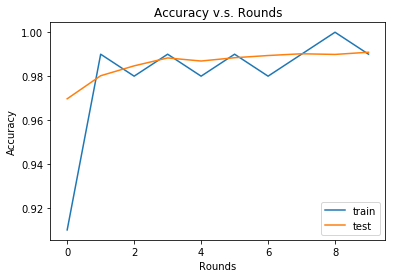

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
train_line = pd.Series(train_accs)
test_line = pd.Series(test_accs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Rounds')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy v.s. Rounds')
ax.set_xlim(-0.5, 9.5)
train_line.plot(kind='line')
test_line.plot(kind='line')
plt.legend(labels=['train', 'test'])
plt.show()


5


(-0.5, 27.5, 27.5, -0.5)

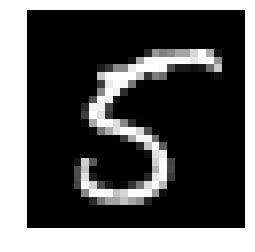

In [31]:
# 先随便找张图片看一下
img5 = mnist.train.images[5]
label5 = mnist.train.labels[5]
print(np.argmax(label5))
img5 = img5.reshape([28, 28])
plt.imshow(img5, cmap='gray')
plt.axis("off")

(1, 28, 28, 32)


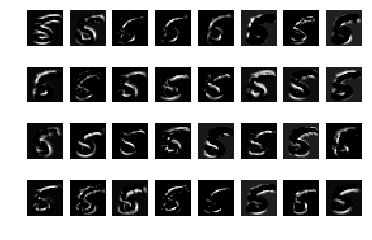

In [37]:
X_img = img5.reshape([-1, 784])
result = sess.run([h_conv1], feed_dict={X_input: X_img, keep_prob: 1.0})[0]
type(result)
print(result.shape)

for i in range(result.shape[-1]):
    show_img = result[:,:,:,i]
    show_img = show_img.reshape([28, 28])
    plt.subplot(4, 8, i+1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
    

可以看出不同的卷积核学习到了不同的轮廓特征